# Regressione Lineare Multipla

In questa esercitazione si utilizza il dataset FuelConsumptionCo2.csv che contiene informazioni sul consumo di carburante per alcuni modelli di automobili ([fonte](http://open.canada.ca/data/en/dataset/98f1a129-f628-4ce4-b24d-6f16bf24dd64)
). Lo scopo è implementare un modello di regressione lineare multipla tramite scikit-learn per predire le emissioni di CO2 partendo da più features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import linear_model

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [ ]:
url= "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%202/data/FuelConsumptionCo2.csv"
dataset = pd.read_csv(url)
display(dataset.sample(5))
print()
display(dataset.info())
print()
display(dataset.describe())

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
851,2014,NISSAN,PATHFINDER,SUV - SMALL,3.5,6,AV,X,12.0,8.9,10.6,27,244
303,2014,DODGE,CHARGER,FULL-SIZE,3.6,6,A8,X,12.4,7.7,10.3,27,237
179,2014,CADILLAC,ESCALADE AWD,SUV - STANDARD,6.2,8,A6,Z,17.0,11.8,14.7,19,338
286,2014,CHRYSLER,300 AWD FFV,FULL-SIZE,3.6,6,A8,X,12.8,8.6,10.9,26,251
799,2014,MINI,COOPER S COUPE,TWO-SEATER,1.6,4,M6,Z,9.1,6.7,8.0,35,184



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB


None

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


In [ ]:
# Rimozione delle features categoriche o non utili ai fini della regressione
dataset = dataset.drop(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION', 'FUELTYPE',],axis=1)

<Axes: >

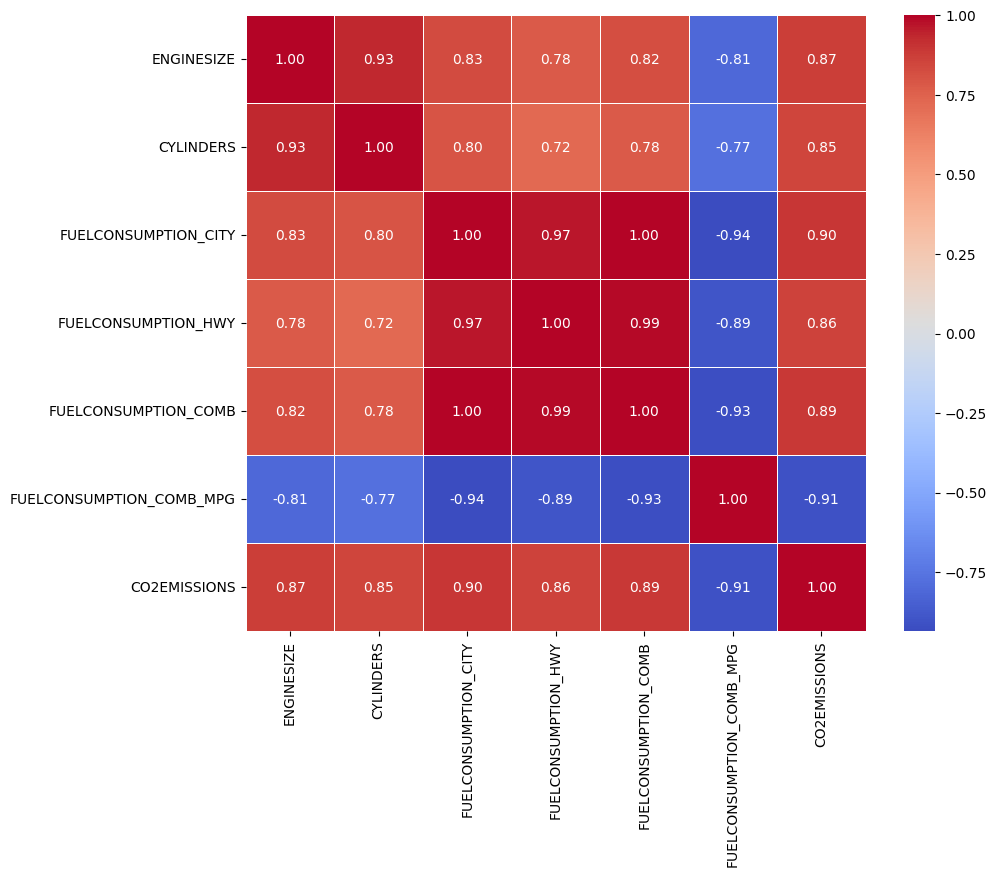

In [ ]:
# Matrice di correlazione delle features numeriche con la varibile target CO2EMISSIONS
correlation_matrix = dataset.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)



Guardando alla tabella di correlazione:

- Tutte le features hanno una correlazione maggiore o uguale a 0.85 con la variabile target;
- ENGINESIZE e CYLINDERS sono molto correlate, ma ENGINESIZE ha una correlazione maggiore con il target, quindi si può eliminare CYLINDERS;
- Stessa cosa per le variabili sul consumo di carburante: FUELCONSUMPTION_COMB_MPG ha una correlazione maggiore con il target, quindi è preferibile rispetto alle altre;

In [ ]:
# Rimozione delle features in base alla matrice di correlazione
dataset = dataset.drop(['CYLINDERS', 'FUELCONSUMPTION_CITY', 'FUELCONSUMPTION_HWY','FUELCONSUMPTION_COMB',], axis=1)
dataset.head()

,ENGINESIZE,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,2.0,33,196
1,2.4,29,221
2,1.5,48,136
3,3.5,25,255
4,3.5,27,244


Una scatter matrix può aiutare a visualizzare il tipo di relazione che lega ciascuna variabile alla variabile target.


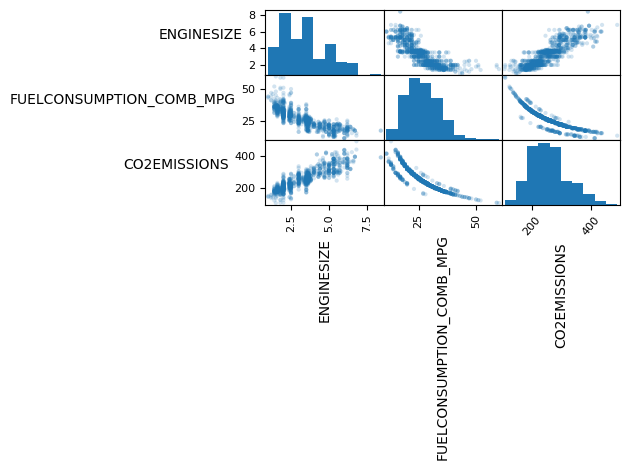

In [ ]:
# Scatter matrix

axes = pd.plotting.scatter_matrix(dataset, alpha=0.2)
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')

plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()


## Preprocessing


In [ ]:
X = dataset.iloc[:,[0,1]].to_numpy()  # ENGINESIZE, FUELCONSUMPTION_COMB_MPG
y = dataset.iloc[:,[2]].to_numpy()

La standardizzazione delle features in input fa in modo che tutte le features abbiano lo stesso peso, e in generale implica la sottrazione della media e la divisione per la deviazione standard; questo si può fare automaticamente con sklearn.
Una variabile standardizzata ha media nulla e deviazione standard uno.


In [ ]:
std_scaler = preprocessing.StandardScaler()
X_std = std_scaler.fit_transform(X)

In [ ]:
# Divisione train e test set
X_train, X_test, y_train, y_test = train_test_split(X_std,y,test_size=0.2,random_state=42)

## Definizione del modello di Regressione Lineare Multipla



In [ ]:
regressor = linear_model.LinearRegression()
regressor.fit(X_train, y_train)  # training

# Coefficienti della regressione
coef_ =  regressor.coef_
intercept_ = regressor.intercept_

print ('Coefficients: ', coef_)
print ('Intercept: ', intercept_)

Coefficients:  [[ 25.27339614 -37.4381472 ]]
Intercept:  [256.29072488]




I parametri trovati descrivono l'iperpiano (piano nel caso bidimensionale) che meglio si adatta ai dati di addestramento. Tali coefficienti devono essere riportati alla scala originale, prima della standardizzazione, altrimenti non potranno essere utilizzati con i dati originali.


In [ ]:
# Media e deviazione standard
means_ = std_scaler.mean_
std_devs_ = np.sqrt(std_scaler.var_)

# Trasformazione nello spazio originale
coef_original = coef_ / std_devs_
intercept_original = intercept_ - np.sum((means_ * coef_) / std_devs_)

print ('Coefficients: ', coef_original)
print ('Intercept: ', intercept_original)

Coefficients:  [[17.8581369  -5.01502179]]
Intercept:  [329.1363967]


Nel caso limite di ENGINESIZE zero e FUELCONSUMPTION_COMB_MPG zero, ci si aspetta CO2EMISSIONS zero; tuttavia, come si può vedere dalla regressione, l'intercetta del piano è diversa da zero. Questo può essere dovuto al fatto che la variabile target non ha una dipendenza del tutto lineare con le altre variabili, oppure alla presenza di outliers che causano una distorsione.


### Visualizzazione della regressione

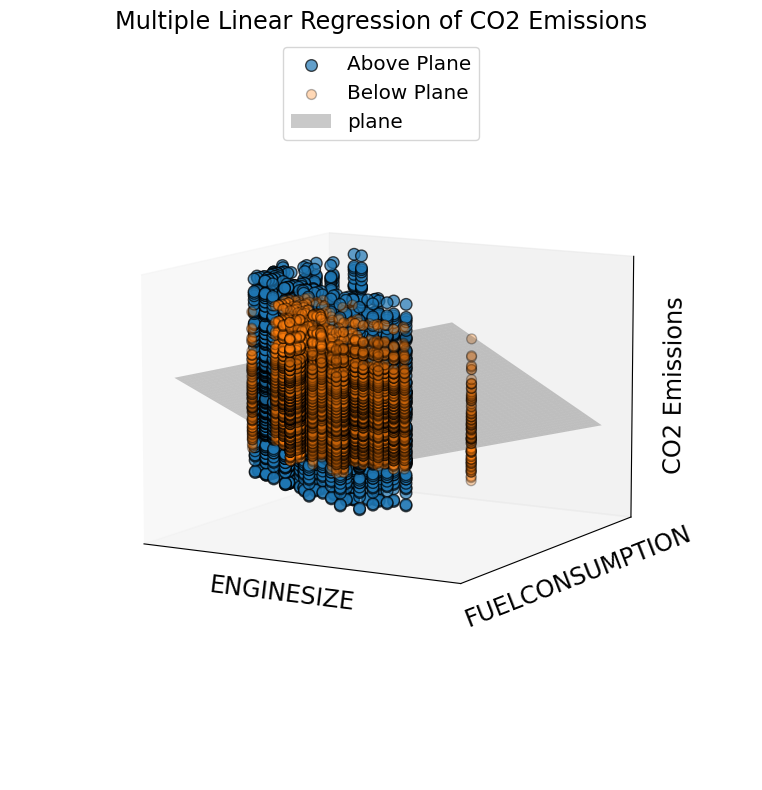

In [ ]:
# Ensure X1, X2, and y_test have compatible shapes for 3D plotting
X1 = X_test[:, 0] if X_test.ndim > 1 else X_test
X2 = X_test[:, 1] if X_test.ndim > 1 else np.zeros_like(X1)

# Create a mesh grid for plotting the regression plane
x1_surf, x2_surf = np.meshgrid(np.linspace(X1.min(), X1.max(), 100),
                               np.linspace(X2.min(), X2.max(), 100))

y_surf = intercept_ +  coef_[0,0] * x1_surf  +  coef_[0,1] * x2_surf

# Predict y values using trained regression model to compare with actual y_test for above/below plane colors
y_pred = regressor.predict(X_test.reshape(-1, 1)) if X_test.ndim == 1 else regressor.predict(X_test)
above_plane = y_test >= y_pred
below_plane = y_test < y_pred
above_plane = above_plane[:,0]
below_plane = below_plane[:,0]

# Plotting
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the data points above and below the plane in different colors
ax.scatter(X1[above_plane], X2[above_plane], y_test[above_plane],  label="Above Plane",s=70,alpha=.7,ec='k')
ax.scatter(X1[below_plane], X2[below_plane], y_test[below_plane],  label="Below Plane",s=50,alpha=.3,ec='k')

# Plot the regression plane
ax.plot_surface(x1_surf, x2_surf, y_surf, color='k', alpha=0.21,label='plane')

# Set view and labels
ax.view_init(elev=10)

ax.legend(fontsize='x-large',loc='upper center')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.set_box_aspect(None, zoom=0.75)
ax.set_xlabel('ENGINESIZE', fontsize='xx-large')
ax.set_ylabel('FUELCONSUMPTION', fontsize='xx-large')
ax.set_zlabel('CO2 Emissions', fontsize='xx-large')
ax.set_title('Multiple Linear Regression of CO2 Emissions', fontsize='xx-large')
plt.tight_layout()
plt.show()

Visualizzazione bidimensionale di ciascuna variabile.


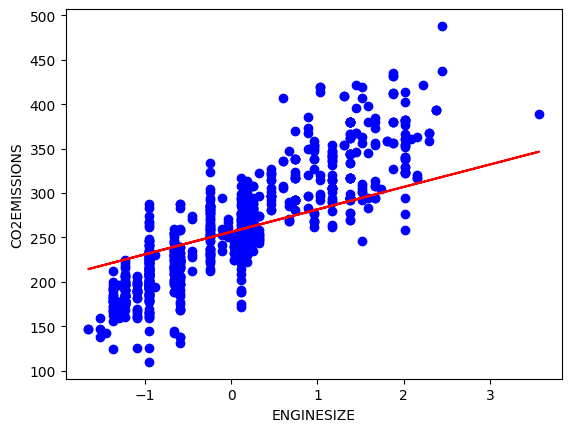

In [ ]:
plt.scatter(X_train[:,0], y_train,  color='blue')
plt.plot(X_train[:,0], coef_[0,0] * X_train[:,0] + intercept_[0], '-r')
plt.xlabel("ENGINESIZE")
plt.ylabel("CO2EMISSIONS")
plt.show()

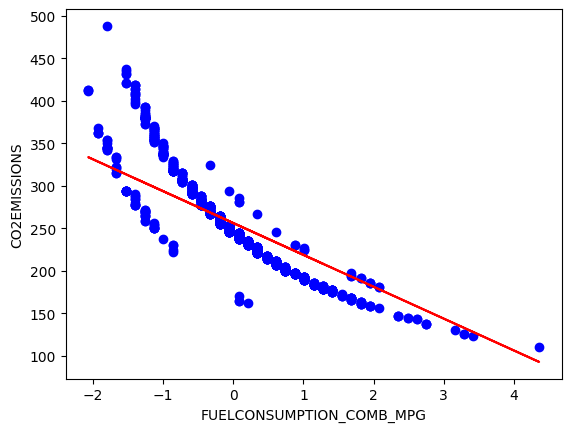

In [ ]:
plt.scatter(X_train[:,1], y_train,  color='blue')
plt.plot(X_train[:,1], coef_[0,1] * X_train[:,1] + intercept_[0], '-r')
plt.xlabel("FUELCONSUMPTION_COMB_MPG")
plt.ylabel("CO2EMISSIONS")
plt.show()

Dunque, la regressione non è andata a buon fine poiché il modello sta cercando di adattare un piano a una superficie non lineare.


